In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, GaussianNoise
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, hamming_loss, accuracy_score, f1_score, precision_score, recall_score

# ------------------------------
# 1. Load and Prepare CSV Vitals Data
# ------------------------------
folder_path = "/content/drive/MyDrive/mediumdataset_csv"  # Update this path if needed

dataframes = []
for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(folder_path, file))
        dataframes.append(df)

df = pd.concat(dataframes, ignore_index=True)

# Rename columns
df.rename(columns={
    'Heart Rate': 'hr',
    'Blood Pressure': 'bp',
    'Body Temperature': 'temp',
    'Oxygen Level': 'oxygen'
}, inplace=True)

df.dropna(subset=['hr', 'bp', 'temp', 'oxygen'], inplace=True)

# ------------------------------
# 2. Add Rule-Based Multi-Label Conditions
# ------------------------------
df['Early Heart Failure']   = ((df['bp'] < 100) & (df['hr'] > 100)).astype(int)
df['Severe Hypoxia']        = (df['oxygen'] < 94).astype(int)
df['Hyperventilation']      = ((df['hr'] > 95) & (df['oxygen'] > 96)).astype(int)
df['Postural Hypotension']  = ((df['bp'] < 95) & (df['hr'] < 70)).astype(int)
df['Mild Infection']        = ((df['temp'] > 37.2) & (df['hr'] < 95)).astype(int)
df['Viral Fever']           = ((df['temp'] > 38.0) & (df['hr'] > 95)).astype(int)
df['Chronic Bronchitis']    = ((df['oxygen'] < 93) & (df['temp'] < 37.5)).astype(int)
df['Cold Exposure']         = (df['temp'] < 36.0).astype(int)
df['POTS']                  = ((df['hr'] > 115) & (df['bp'] > 100)).astype(int)
df['Allergic Reaction']     = ((df['hr'] > 100) & (df['bp'] > 115) & (df['temp'] > 37)).astype(int)

# ------------------------------
# 3. Features and Labels
# ------------------------------
X = df[['hr', 'bp', 'temp', 'oxygen']].values
label_columns = [
    'Early Heart Failure', 'Severe Hypoxia', 'Hyperventilation',
    'Postural Hypotension', 'Mild Infection', 'Viral Fever',
    'Chronic Bronchitis', 'Cold Exposure', 'POTS', 'Allergic Reaction'
]
y = df[label_columns].values

# ------------------------------
# 4. Preprocessing
# ------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ------------------------------
# 5. Model (MFIL-Net + Simulated VRN)
# ------------------------------
def build_model(input_dim, output_dim):
    inputs = Input(shape=(input_dim,), name="Input_Vitals")
    x = GaussianNoise(0.1, name="Simulated_VRN_Noise")(inputs)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(output_dim, activation='sigmoid')(x)
    return Model(inputs, outputs)

model = build_model(input_dim=4, output_dim=10)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# ------------------------------
# 6. Train
# ------------------------------
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# ------------------------------
# -----------------------------


# ------------------------------
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score,
    accuracy_score, hamming_loss, roc_auc_score, precision_recall_curve, auc, multilabel_confusion_matrix
)

y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# 1. Global Metrics (normal = flattened)
y_test_flat = y_test.ravel()
y_pred_flat = y_pred_binary.ravel()
y_prob_flat = y_pred.ravel()

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test_flat, y_pred_flat).ravel()

# Standard Metrics
accuracy = accuracy_score(y_test_flat, y_pred_flat)
precision = precision_score(y_test_flat, y_pred_flat, zero_division=0)
recall = recall_score(y_test_flat, y_pred_flat, zero_division=0)
f1 = f1_score(y_test_flat, y_pred_flat, zero_division=0)
hamming = hamming_loss(y_test_flat, y_pred_flat)

# Specificity and Sensitivity
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
sensitivity = recall  # Sensitivity == Recall

# ROC and PR AUC
try:
    roc_auc = roc_auc_score(y_test_flat, y_prob_flat)
except:
    roc_auc = 0.0

try:
    precision_curve, recall_curve, _ = precision_recall_curve(y_test_flat, y_prob_flat)
    pr_auc = auc(recall_curve, precision_curve)
except:
    pr_auc = 0.0

# 2. Print All Metrics
print("\n✅ Global Binary Evaluation (All Labels Flattened):")
print(f"Accuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"F1 Score     : {f1:.4f}")
print(f"Hamming Loss : {hamming:.4f}")
print(f"Specificity  : {specificity:.4f}")
print(f"Sensitivity  : {sensitivity:.4f}")
print(f"ROC AUC      : {roc_auc:.4f}")
print(f"PR AUC       : {pr_auc:.4f}")
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")



# ------------------------------
# 8. Rule Interpreter (Debug Sample)
# ------------------------------
def rule_interpreter(sample):
    hr, bp, temp, oxygen = sample
    return {
        "Early Heart Failure": int(bp < 100 and hr > 100),
        "Severe Hypoxia": int(oxygen < 94),
        "Hyperventilation": int(hr > 95 and oxygen > 96),
        "Postural Hypotension": int(bp < 95 and hr < 70),
        "Mild Infection": int(temp > 37.2 and hr < 95),
        "Viral Fever": int(temp > 38.0 and hr > 95),
        "Chronic Bronchitis": int(oxygen < 93 and temp < 37.5),
        "Cold Exposure": int(temp < 36.0),
        "POTS": int(hr > 115 and bp > 100),
        "Allergic Reaction": int(hr > 100 and bp > 115 and temp > 37)
    }

print("\n🧠 Rule-Based Interpretability Example:")
for i in range(3):
    print(f"\nSample {i+1}: {X[i]}")
    print(rule_interpreter(X[i]))

# ------------------------------
# 9. TODO: Add VRN Feature Engineering (Signal Coherence)
# ------------------------------
print("\n🛠️ TODO: Add FFT / Wavelet-based feature engineering for full VRN pipeline.")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Vitals (InputLayer)       │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Simulated_VRN_Noise             │ (None, 4)              │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,314 (40.29 KB)

 Trainable params: 9,930 (38.79 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.3644 - loss: 0.6176 - val_accuracy: 0.4892 - val_loss: 0.1946
Epoch 2/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4848 - loss: 0.1838 - val_accuracy: 0.5538 - val_loss: 0.1179
Epoch 3/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4972 - loss: 0.1346 - val_accuracy: 0.5581 - val_loss: 0.0914
Epoch 4/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4910 - loss: 0.1163 - val_accuracy: 0.5411 - val_loss: 0.0863
Epoch 5/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4981 - loss: 0.1068 - val_accuracy: 0.5561 - val_loss: 0.0768
Epoch 6/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5033 - loss: 0.0988 - val_accuracy: 0.5261 - val_loss: 0.0721
Epoch 7/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4854 - loss: 0.0963 - val_accuracy: 0.5437 - val_loss: 0.0683
Epoch 8/20
384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5079 - loss: 0.0938 - val_accuracy: 0.

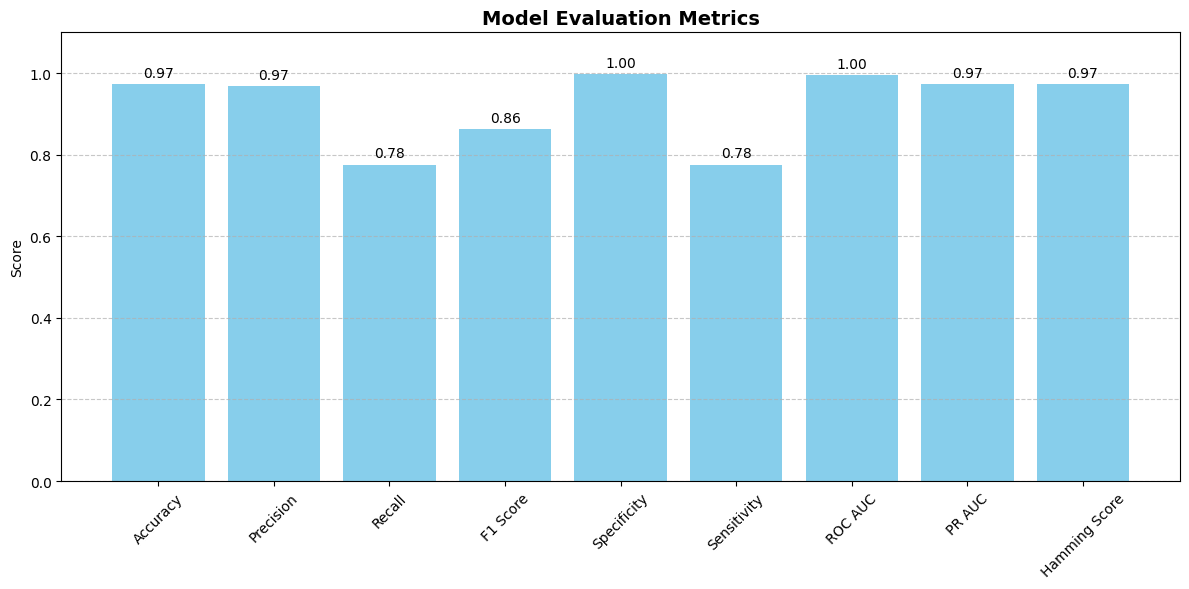

In [ ]:
import matplotlib.pyplot as plt

# Example metric values from your code (make sure these match your actual variables)
metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "Specificity": specificity,
    "Sensitivity": sensitivity,
    "ROC AUC": roc_auc,
    "PR AUC": pr_auc,
    "Hamming Score": 1 - hamming  # converting from loss to score
}

# Plotting
plt.figure(figsize=(12, 6))
bars = plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.ylim(0, 1.1)

# Annotate values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{height:.2f}",
             ha='center', va='bottom', fontsize=10)

plt.title("Model Evaluation Metrics", fontsize=14, weight='bold')
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
